In [5]:
from icp_oes import agilent
from icp_oes.calibration import polynomial

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import uncertainties.unumpy as unp

f = 'test_data/250130_Seawaters.csv'

In [2]:
crm_name = 'IAPSO'  # name of CRM

In [3]:
dat = agilent.load(f)
dat.dropna(inplace=True)

In [4]:
blanks = dat.loc[dat.index.str.contains('Blank')].mean(axis=0)
dat -= blanks

In [5]:
crm = pd.read_csv(f'examples/aquarium_workflow/crm/{crm_name}.csv')  # load CRM data
crm.set_index('element', inplace=True)

In [6]:
crms = dat.loc[dat.index.str.contains(crm_name)]
crms.index = crms.index.str.replace(crm_name + 'f', '').astype(float)
# get reference values for CRM
crms_refvals = crms.copy()

In [7]:
for el in crms_refvals.columns.levels[0]:
    if el not in crm.index:
        continue
    refvals = np.zeros(crms_refvals.loc[:, el].shape)
    refvals[:] = crm.loc[el, 'value']
    refvals *= crms_refvals.index.values.reshape(-1,1)
    
    crms_refvals.loc[:, el] = refvals

In [8]:
# calculate calibrations
coefs = {}
best = {}

for el in crms.columns.levels[0]:
    sub = crms.loc[:, [el]]
    sub_ref = crms_refvals.loc[:, [el]]
    for c in sub.columns:    
        # line fitting
        cal = polynomial(sub[c].values, sub_ref[c].values, 1)
        coefs[c] = cal
    
    best_r2 = -999
    for c in sub.columns:
        if coefs[c].r2 > best_r2:
            best[el] = c
            best_r2 = coefs[c].r2


/tmp/ipykernel_802099/4219357291.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  n_bands = crms.groupby(level=0, axis=1).size().max()


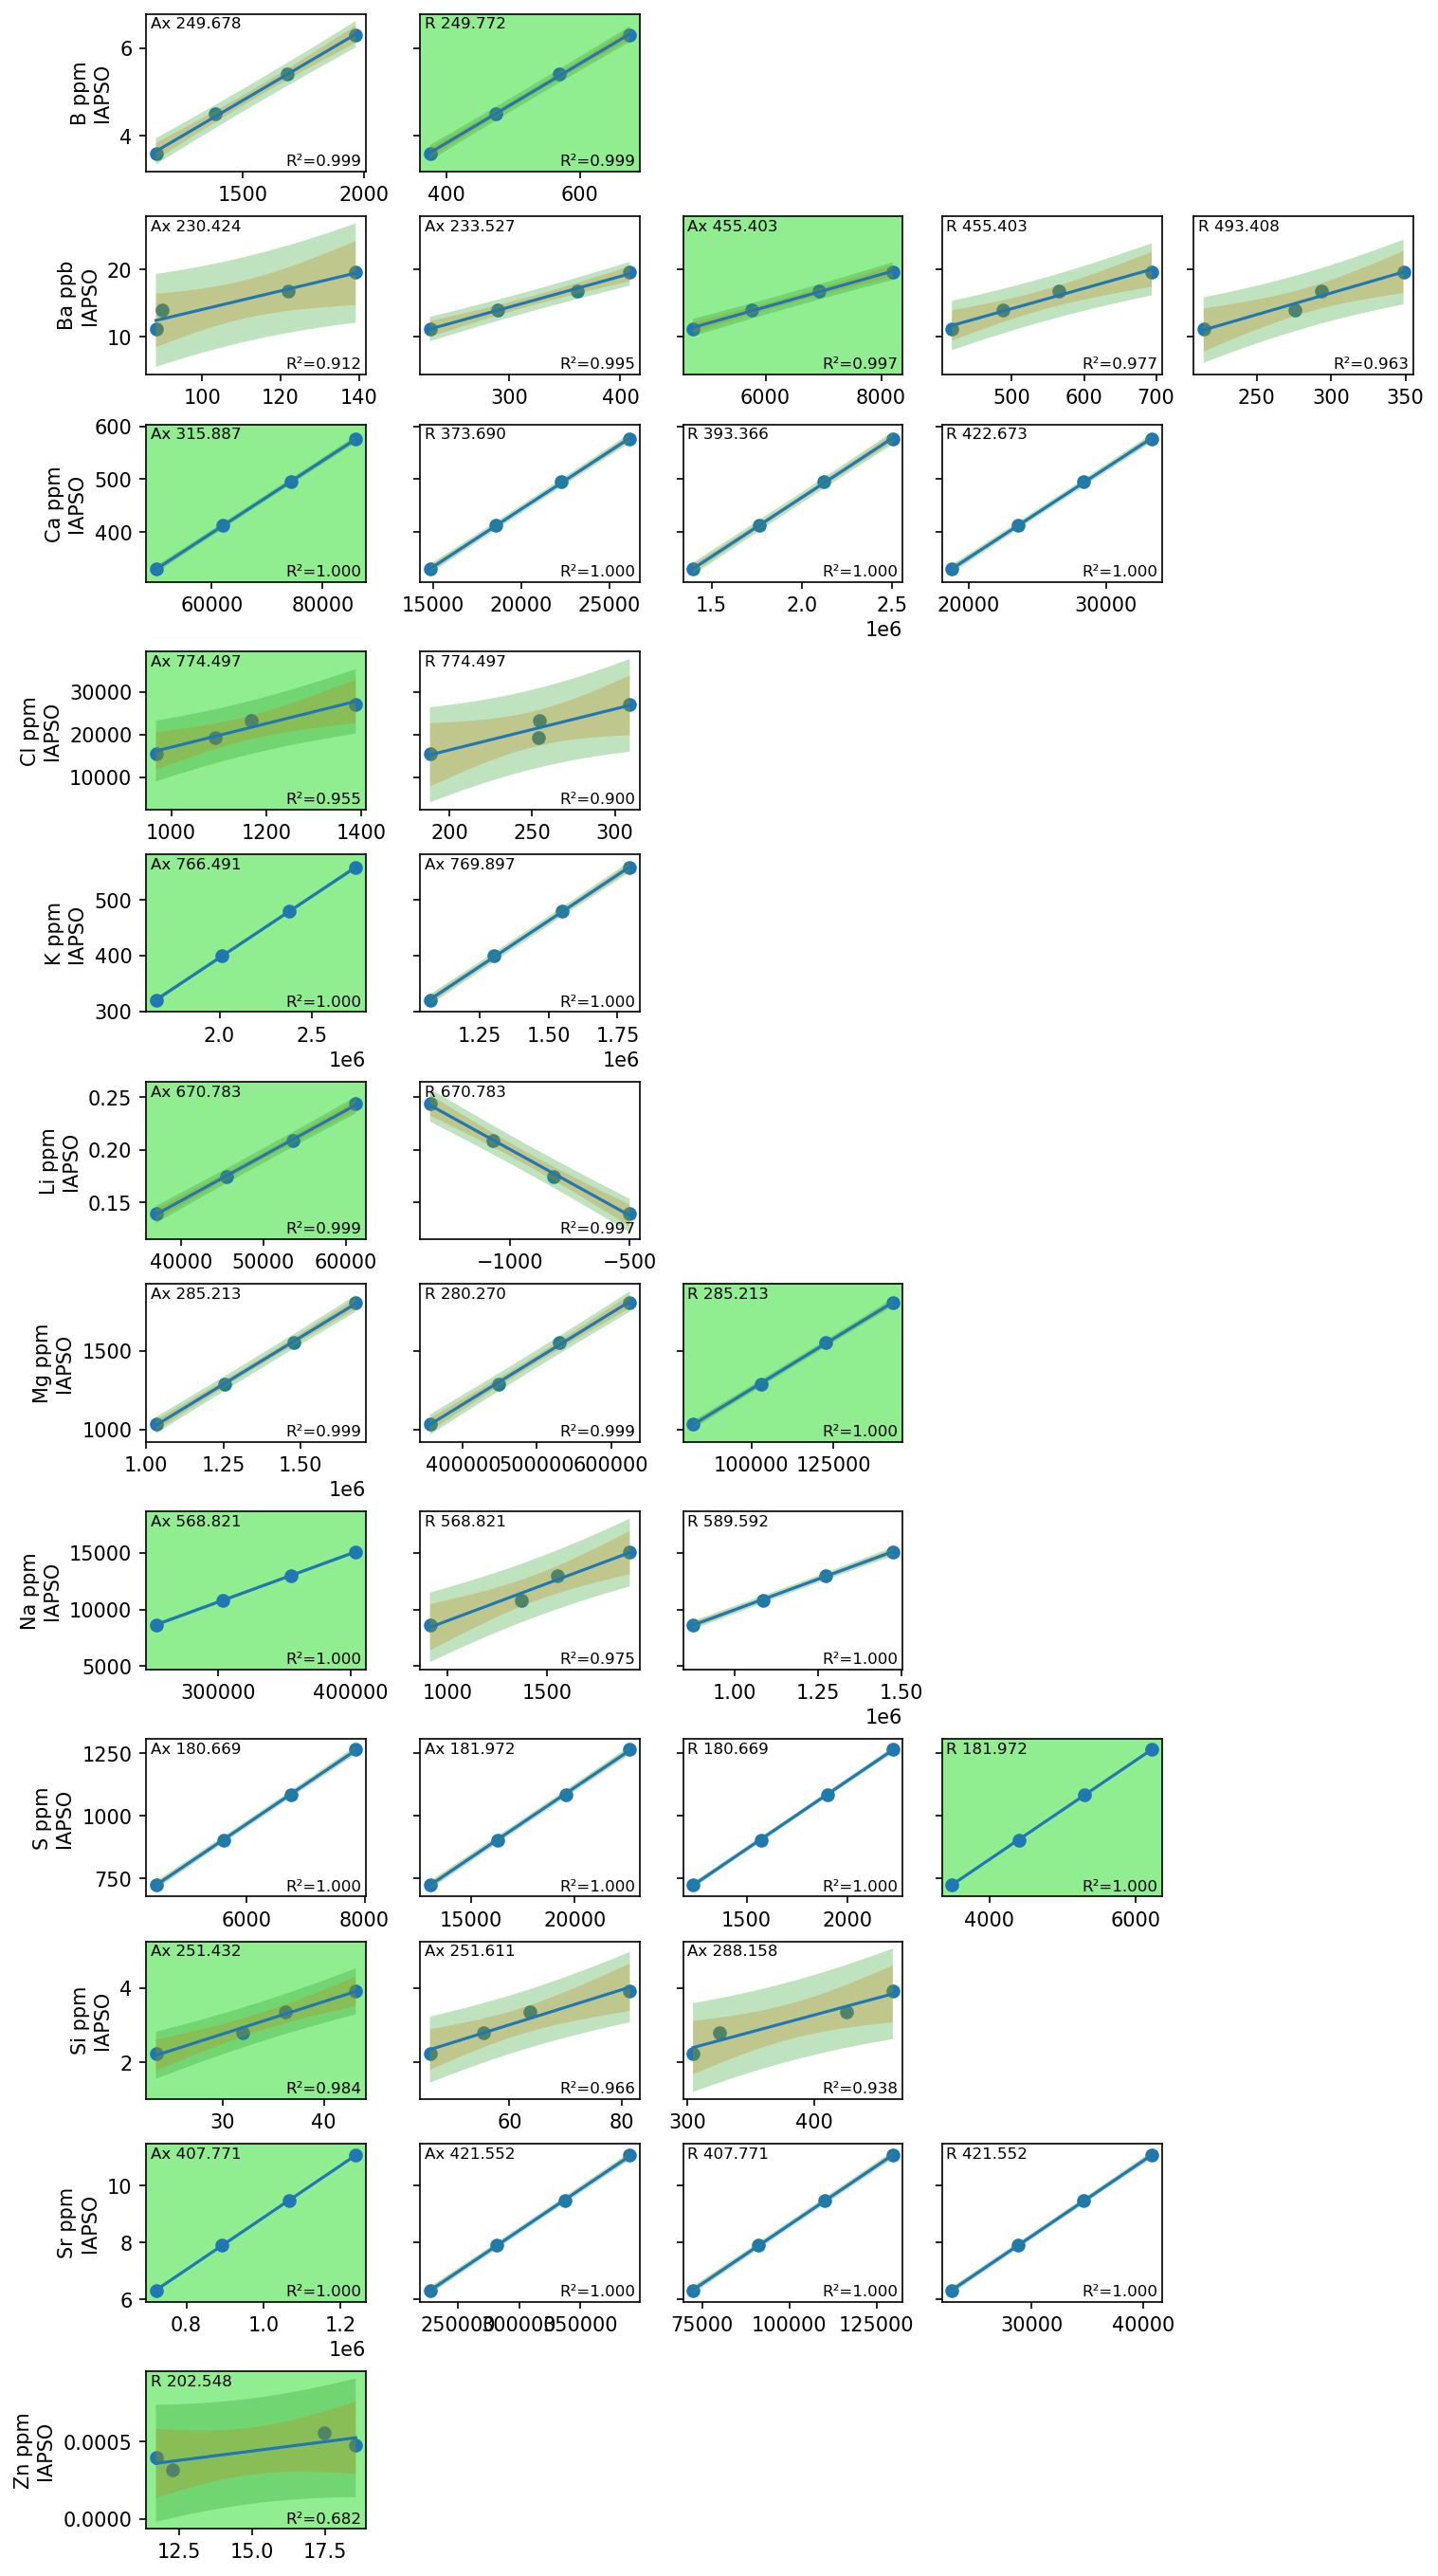

In [9]:
n_bands = crms.groupby(level=0, axis=1).size().max()
n_elements = len(crms.columns.levels[0])

fig, axs = plt.subplots(n_elements, n_bands, figsize=(n_bands*2, n_elements*1.5), constrained_layout=True, sharey='row')

for el, row in zip(crms.columns.levels[0], axs):
    sub = crms.loc[:, [el]]
    sub_ref = crms_refvals.loc[:, [el]]
    
    i = 0
    for c, ax in zip(sub.columns, row):
        ax.scatter(sub[c], sub_ref[c], label=c)
        i += 1

        cal = coefs[c]
        
        ax.text(0.98, 0.02, f'R²={cal.r2:.3f}', transform=ax.transAxes, ha='right', va='bottom', fontsize=8)
        ax.text(0.02, 0.98, ' '.join(c[1:]), transform=ax.transAxes, ha='left', va='top', fontsize=8)

        if c == best[el]:
            ax.set_facecolor('lightgreen')
            
        ux = np.linspace(sub[c].min(), sub[c].max(), 100)
        
        pred, ci, pi = cal.predict(ux)
                
        ax.plot(ux, pred)
        ax.fill_between(ux, pred - ci, pred + ci, alpha=0.3)
        ax.fill_between(ux, pred - pi, pred + pi, alpha=0.3)
        
    for ax in row[i:]:
        ax.axis('off')    
        
    unit = crm.loc[el, 'unit']
    row[0].set_ylabel(f'{el} {unit}\n{crm_name}')

In [17]:
samples = dat.loc[dat.index.str.contains('aquarium')]

calibrated = samples.copy().astype(object)

for c, cal in coefs.items():
    pred, _, pi = cal.predict(samples.loc[:, c])
    calibrated.loc[:, c] = unp.uarray(pred, pi.values)
    
calibrated_best = calibrated.loc[:, best.values()]

cols = []
for el, c in best.items():
    cols.append((el, '_'.join(c[1:]), crm.loc[el, 'unit']))
    
calibrated_best.columns = pd.MultiIndex.from_tuples(cols)

calibrated_best.index = pd.MultiIndex.from_tuples([(tank, pd.to_datetime(date, format='%d/%m/%y')) for  _, tank, date in calibrated_best.index.str.split('_')])

In [18]:
calibrated_best

B          Ba         Ca               Cl  \
                   R_249.772  Ax_455.403 Ax_315.887       Ax_774.497   
                         ppm         ppb        ppm              ppm   
main 2024-11-07  4.32+/-0.16   1.4+/-2.5    379+/-6  (1.9+/-0.7)e+04   
     2024-11-14  4.55+/-0.16   1.9+/-2.5    399+/-6  (1.7+/-0.7)e+04   
     2024-11-21  4.54+/-0.16   1.8+/-2.5    401+/-6  (1.8+/-0.7)e+04   
     2024-11-26  4.52+/-0.16   1.0+/-2.6    404+/-6  (1.8+/-0.7)e+04   
     2024-12-03  4.77+/-0.15   0.2+/-2.7    430+/-6  (1.7+/-0.7)e+04   
     2024-12-10  4.73+/-0.15  -0.4+/-2.8    435+/-6  (2.0+/-0.6)e+04   
     2024-12-26  4.76+/-0.15   1.2+/-2.5    418+/-6  (1.6+/-0.7)e+04   
     2024-12-31  4.75+/-0.15   1.1+/-2.6    416+/-6  (1.7+/-0.7)e+04   
     2025-01-07  4.92+/-0.15   0.9+/-2.6    414+/-6  (1.9+/-0.6)e+04   
     2025-01-14  5.16+/-0.15   0.7+/-2.6    434+/-6  (1.6+/-0.7)e+04   
     2025-01-21  5.17+/-0.15   0.1+/-2.7    440+/-6  (1.7+/-0.7)e+04   
     2025-01-28  5.19+/-0.15   0.0+/-2.7    441+/-6  (1.8+/-0.7)e+04   

                           K             Li         Mg                   Na  \
                  Ax_766.491     Ax_670.783  R_285.213           Ax_568.821   
                         ppm            ppm        ppm                  ppm   
main 2024-11-07  437.6+/-3.4  0.226+/-0.007  1403+/-22  (1.056+/-0.015)e+04   
     2024-11-14  440.2+/-3.4  0.231+/-0.008  1445+/-22  (1.066+/-0.015)e+04   
     2024-11-21  437.0+/-3.4  0.233+/-0.008  1468+/-22  (1.071+/-0.014)e+04   
     2024-11-26  433.9+/-3.4  0.234+/-0.008  1479+/-22  (1.067+/-0.015)e+04   
     2024-12-03  439.5+/-3.4  0.237+/-0.008  1517+/-22  (1.077+/-0.014)e+04   
     2024-12-10  432.9+/-3.4  0.237+/-0.008  1523+/-22  (1.073+/-0.014)e+04   
     2024-12-26  421.9+/-3.4  0.235+/-0.008  1532+/-22  (1.065+/-0.015)e+04   
     2024-12-31  423.2+/-3.4  0.238+/-0.008  1556+/-22  (1.069+/-0.014)e+04   
     2025-01-07  421.1+/-3.4  0.240+/-0.008  1584+/-23  (1.067+/-0.014)e+04   
     2025-01-14  430.7+/-3.4  0.249+/-0.008  1660+/-23  (1.087+/-0.014)e+04   
     2025-01-21  428.4+/-3.4  0.253+/-0.008  1664+/-23  (1.091+/-0.014)e+04   
     2025-01-28  418.3+/-3.4  0.251+/-0.008  1665+/-23  (1.076+/-0.014)e+04   

                        S         Si           Sr                Zn  
                R_181.972 Ax_251.432   Ax_407.771         R_202.548  
                      ppm        ppm          ppm               ppm  
main 2024-11-07   948+/-5  0.9+/-1.0  6.22+/-0.05   0.0000+/-0.0009  
     2024-11-14   968+/-5  1.4+/-0.8  6.70+/-0.05   0.0000+/-0.0010  
     2024-11-21   982+/-5  0.6+/-1.1  6.45+/-0.05   0.0000+/-0.0009  
     2024-11-26   983+/-5  0.9+/-1.0  6.49+/-0.05  -0.0001+/-0.0011  
     2024-12-03  1008+/-5  0.8+/-1.0  6.87+/-0.05  -0.0002+/-0.0013  
     2024-12-10  1011+/-5  0.6+/-1.1  6.83+/-0.05  -0.0000+/-0.0010  
     2024-12-26  1006+/-5  0.3+/-1.2  6.28+/-0.05   0.0000+/-0.0009  
     2024-12-31  1017+/-5  0.4+/-1.1  6.16+/-0.05   0.0002+/-0.0006  
     2025-01-07  1029+/-5  0.4+/-1.1  6.09+/-0.06  -0.0000+/-0.0010  
     2025-01-14  1084+/-5  0.7+/-1.1  6.53+/-0.05   0.0000+/-0.0009  
     2025-01-21  1092+/-5  1.3+/-0.9  6.65+/-0.05   0.0001+/-0.0009  
     2025-01-28  1088+/-5  0.5+/-1.1  6.84+/-0.05   0.0001+/-0.0007